## La falacia de "comprar barato y vender caro" (y lo que nos dicen los datos)

A todos nos ha pasado. Miras un gráfico histórico del S&P 500 o cualquier otro índice y piensas: "Está clarísimo. Solo había que comprar en esta caída y vender en este pico". La teoría sobre datos históricos es impecable, pero la práctica es incierta: en tiempo real, nunca sabes si estás en un "suelo" o si todavía queda caída libre por delante.

In [1]:
import pandas as pd
import yfinance as yf
import warnings
import matplotlib.pyplot as plt
from scipy import optimize 
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

warnings.filterwarnings("ignore")

In [2]:

# Get and process 'S&P 500' and 'Fear and Greed Index' data
# CNN fear and greed data source: https://www.finhacker.cz/fear-and-greed-index-historical-data-and-chart/ (Inspect>Network and preview biggest file)
df_fear_greed = pd.read_json('./data/fear_and_greed.json')

df_fear_greed["date"] = pd.to_datetime(df_fear_greed['date'])
df_fear_greed = df_fear_greed[["date", "value"]]

start_date = df_fear_greed["date"].min()
end_date = df_fear_greed["date"].max()

df_sp500 = yf.download('SPY', start=start_date, end=end_date, progress=False)
df_sp500 = df_sp500.droplevel(1, axis=1)
df_sp500 = df_sp500.reset_index()
df_sp500 = df_sp500.rename(columns={"Date": "date"})

df_total = pd.merge(df_sp500, df_fear_greed, on='date', how='left')
df_total["Year"] = df_total["date"].dt.year
df_total["Month"] = df_total["date"].dt.month
df_total["Day"] = df_total["date"].dt.day

df_total = df_total.drop_duplicates(subset=['date'], keep='first')
df_total = df_total.set_index('date').sort_index()

In [3]:
def plot_candlestick_with_bg(df):
    df = df[(df.Year >= 2011) & (df.Year <= 2019)]
    df = df.reset_index()
    shapes = []
    for i in range(len(df)):
        val = df.loc[i, 'value']

        sat = 90
        ints = 80
        hue = (val / 100.0) * 120
        bg_color = f'hsl({hue}, {sat}%, {ints}%)'

        legend_data = [
            (0, "Extreme Fear (0 - 25)", f'hsl(0, {sat}%, {ints}%)'),
            (50, "Neutral (26 - 74)", f'hsl(60, {sat}%, {ints}%)'),
            (100, "Extreme Greed (75 - 100)", f'hsl(120, {sat}%, {ints}%)'),
        ]
        
    
        x0 = df.loc[i, 'date']
        if i < len(df) - 1:
            x1 = df.loc[i+1, 'date']
        else:
            if i > 0:
                time_diff = df.loc[i, 'date'] - df.loc[i-1, 'date']
                x1 = df.loc[i, 'date'] + time_diff
            else:
                x1 = df.loc[i, 'date'] + pd.Timedelta(days=1)

        shape = {
            'type': "rect",
            'xref': "x", 
            'yref': "paper", 
            'x0': x0,
            'y0': 0,
            'x1': x1,
            'y1': 1,
            'fillcolor': bg_color,
            'layer': "below",  
            'line_width': 0,  
        }
        shapes.append(shape)

    fig = go.Figure()

    fig.add_trace(go.Candlestick(
        x=df['date'],
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name='SP500'
    ))

    for val, name, color in legend_data:
        fig.add_trace(go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(size=10, color=color, symbol='square'),
            name=name,
            legendgroup='F&G',
            showlegend=True,
        ))


    return fig.update_layout(
        title='SP500 & Fear and Greed Index',
        xaxis_title='Date',
        yaxis_title='Price',
        shapes=shapes,
        xaxis_rangeslider_visible=False,
        plot_bgcolor='rgba(0,0,0,0)',
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False),
        height=720,
        width=1920
    )

plot_candlestick_with_bg(df_total)

Para intentar poner gestionar esa incertidumbre, existen cientos de indicadores técnicos que pueden ayudarnos a identificar por qué caminos puede moverse el mercado, aunque la mayoría de ellos requieren conocimiento experto para entenderlos y poder aplicarlos. En este estudio emplearé uno bastante intuitivo que intenta medir el estado emocional del mercado: el **Fear and Greed Index** (Índice de Miedo y Codicia). Su mecánica es simple: una escala del 0 al 100 donde los extremos identifican los momentos de pánico y euforia.

Antes de implementar cualquier estrategia, quise comprobar si el indicador realmente se mueve al mismo ritmo que el mercado. Para ello, analicé su correlación histórica con el S&P 500, poniendo el foco en los desfases temporales (lags) para ver si el sentimiento anticipa al precio o viceversa.

In [4]:
# 1. Definir los rangos
day_ranges = [-30, -15, -10, -5, 1, 5, 10, 15, 30, 45, 60, 90]
results = []

# Supongamos que df_total es tu DataFrame original
df_corr_calc = df_total.copy()

# 2. Calcular las correlaciones
for r in day_ranges:
    col_diff = f"{-r}-days-diff"
    # Cálculo del cambio porcentual
    df_corr_calc[col_diff] = (df_corr_calc["Close"].diff(r) / df_corr_calc["Close"].shift(r))
    
    # Calcular correlación con 'value' (Fear & Greed)
    corr = df_corr_calc[col_diff].corr(df_corr_calc['value'])
    results.append({'Days Range': -r, 'Correlation': corr})

# 3. Crear DataFrame para el gráfico
df_plot = pd.DataFrame(results)

# 4. Crear el gráfico con Plotly Express
fig = px.line(
    df_plot, 
    x='Days Range', 
    y='Correlation', 
    markers=True,
    title='Correlation between Fear & Greed and SP500 Growth over different ranges'
)

# 5. Personalización del estilo (equivalente a Seaborn whitegrid)
fig.update_layout(
    template='plotly_white',
    xaxis_title='Time Range (Days)',
    yaxis_title='Pearson Correlation Coefficient',
    yaxis=dict(range=[0, 1]), # Ajustar límites del eje Y
    title_font_size=16,
    width=1920,
    height=720
)

# Añadir línea horizontal en 0
fig.add_hline(y=0, line_dash="dash", line_color="gray")

# Ajustar grosor de línea y tamaño de marcadores
fig.update_traces(line=dict(width=2.5), marker=dict(size=8))

fig.show()

**¿El resultado?** El indicador no funciona como una bola de cristal, sino como un espejo retrovisor. La correlación es alta con lo que hizo el mercado en los últimos 30 días, pero nula con el futuro. Es lógico: el sentimiento es **reactivo**. Primero el mercado se desploma y aparece el miedo, o rompe máximos y se dispara la codicia; no al revés.

Sabiendo que el índice no anticipa el futuro, sino que certifica el estado actual (sea pánico o éxtasis), planteé la hipótesis: ¿Podemos usar esas señales de 'pánico' o 'euforia' para operar sistemáticamente y batir a una estrategia pasiva?

## Comparativa de estrategias

Para validar la eficacia real de este indicador, es necesario ir más allá de la teoría y someterlo a un **backtesting** riguroso. He diseñado un experimento enfrentando tres estrategias distintas, sobre un escenario con igualdad de condiciones: todas ellas cuentan con una aportación mensual recurrente de 300€ que deberán gestionar según su

1. **DCA (Dollar Cost Averaging):** Es la estrategia que utilizamos como baseline. Consiste en invertir esa cuota mensual el mismo día de cada mes, sin mirar el precio, las noticias o el gráfico. ¿Por qué usarla como referencia? Porque elimina totalmente el factor emocional y el error humano. Si una estrategia compleja que requiere vigilancia no es capaz de batir a una que te lleva 5 minutos al mes, entonces no merece la pena el esfuerzo.

2. **Buy the Fear:** Esta estrategia parte de la premisa de que solo debemos comprar cuando hay miedo en los mercados. El algoritmo acumula la liquidez mes a mes y solo ejecuta compras cuando el Fear and Greed Index cae por debajo de 20 (Miedo Extremo). Nunca vende, solo acumula en los momentos de pánico.

3. **Fear & Greed Swing:** La versión más agresiva. Compra cuando hay miedo (<20) igual que la anterior, pero intenta cerrar caja vendiendo un porcentaje de la cartera cuando el mercado entra en euforia (>90). Busca aprovechar el ciclo completo: comprar barato y vender caro para recomprar después. En esta estrategia hay que tener en cuenta que, al vender posiciones, se deben pagar impuestos por los beneficios antes de poder reinvertir ese dinero. En cambio, en el resto de estrategias el pago fiscal se difiere hasta el momento de liquidar la cartera.

## Las Métricas: Cómo medir el éxito

Para validar la eficacia real de este indicador, es necesario ir más allá de la teoría y someterlo a un backtesting riguroso. He diseñado un experimento enfrentando tres estrategias distintas sobre un escenario con igualdad de condiciones: todas ellas cuentan con una aportación mensual recurrente de 300€ que deberán gestionar según su propia lógica operativa:

- **Net Value (Valor Neto):** De nada sirve tener mucho dinero "teórico" si Hacienda pasa por caja cada vez que rotas la cartera. Esta métrica calcula el dinero real en tu bolsillo tras impuestos, penalizando a las estrategias activas: cada venta intermedia anticipa el pago fiscal, restando capital que deja de generar interés compuesto.

- **MWR / XIRR (Rentabilidad Ponderada):** El ROI simple puede ser engañoso cuando haces aportaciones mensuales. El XIRR es mucho más preciso porque pondera el factor tiempo: reconoce que el capital antiguo ha tenido años para generar interés compuesto, mientras que el dinero reciente apenas ha empezado a trabajar. Es la única forma justa de medir una inversión progresiva.

- **Max Drawdown (El factor "Estómago"):** Mide el porcentaje máximo que ha perdido la cartera desde un pico anterior. Es fundamental porque, en el Excel, aguantar un -40% es fácil, pero en la vida real es lo que diferencia a quien mantiene el plan de quien vende todo por pánico en el peor momento posible. Además, cuanto mayor es la caída, más difícil es recuperarse (si caes un 50%, necesitas subir un 100% solo para volver al inicio)

- **Cash Drag (El coste de oportunidad):** Mide qué porcentaje del tiempo tu dinero estuvo "parado" en efectivo esperando una señal de entrada. Tener liquidez reduce la volatilidad, sí, pero el precio a pagar es una pérdida constante de poder adquisitivo frente a la inflación y al crecimiento del mercado.

In [5]:
class Strategy:
    """
    Base class handling core financial logic, now including:
    - Maximum Drawdown Calculation
    - XIRR (Annualized Return)
    """
    def __init__(self, data: pd.DataFrame, monthly_income: float, initial_cash: float, tax_rate: float = 0.19):
        self.data = data.copy()
        
        # Portfolio State
        self.current_cash = initial_cash
        self.total_shares = 0.0
        self.avg_buy_price = 0.0
        
        # History for Drawdown calculation
        self.portfolio_history = []  # List to store daily portfolio values
        self.dates_history = []      # List to store dates corresponding to values
        self.invested_capital_history = [] # Cumulative "Out of Pocket" cash over time

        # Optimization: Track running total of injected capital
        self.running_invested_capital = initial_cash
        
        # Cash flows for XIRR
        self.cash_flows = []
        self.cash_flows.append((data.index[0], -initial_cash))
        
        # Config
        self.monthly_income = monthly_income
        self.tax_rate = tax_rate
        self.last_month = None
        self.total_tax_paid = 0.0
    
    def _add_monthly_income(self, date):
        """Adds monthly income to cash."""
        self.current_cash += self.monthly_income
        self.cash_flows.append((date, -self.monthly_income))

        # Update running total of invested capital
        self.running_invested_capital += self.monthly_income

    def _buy(self, price, amount_to_invest):
        """Centralized buying logic."""
        if self.current_cash < amount_to_invest:
            amount_to_invest = self.current_cash # Buy as much as possible if cash is insufficient
        
        if amount_to_invest <= 0:
            return

        shares_to_buy = amount_to_invest / price
        
        # New Avg Price = ((Old Shares * Old Price) + (New Shares * Current Price)) / Total Shares
        current_equity_cost = self.total_shares * self.avg_buy_price
        new_equity_cost = shares_to_buy * price
        
        self.total_shares += shares_to_buy
        self.avg_buy_price = (current_equity_cost + new_equity_cost) / self.total_shares
        
        self.current_cash -= amount_to_invest

    def _sell(self, price, percentage_to_sell):
        """Centralized selling logic with taxes."""
        if percentage_to_sell <= 0 or self.total_shares <= 0:
            return

        shares_to_sell = self.total_shares * percentage_to_sell
        
        # 1. Calculate Realized Gain/Loss
        cost_basis = shares_to_sell * self.avg_buy_price # The cost basis for this specific portion
        gross_proceeds = shares_to_sell * price          # Gross amount received
        capital_gain = gross_proceeds - cost_basis
        
        # 2. Calculate Taxes (Only if there is a gain)
        tax = 0.0
        if capital_gain > 0:
            tax = capital_gain * self.tax_rate
        
        self.total_tax_paid += tax
        
        # 3. Update Cash (Net of taxes)
        net_proceeds = gross_proceeds - tax
        self.current_cash += net_proceeds
        
        # 4. Update Shares
        self.total_shares -= shares_to_sell
        
    def get_gross_portfolio_value(self, current_price):
        """
        Returns the Gross Value (Cash + Shares). 
        Useful for charting the portfolio curve over time before taxes.
        """
        return (self.total_shares * current_price) + self.current_cash

    def get_net_liquidation_value(self, current_price):
        """
        Calculates the REAL value if you closed all positions today.
        It subtracts the latent taxes on unrealized gains.
        """
        # 1. Gross value of current shares
        gross_stock_value = self.total_shares * current_price
        
        # 2. Cost basis of current shares
        cost_basis = self.total_shares * self.avg_buy_price
        
        # 3. Unrealized Gain (Latent)
        unrealized_gain = gross_stock_value - cost_basis
        
        # 4. Calculate Pending Tax
        pending_tax = 0.0
        if unrealized_gain > 0:
            pending_tax = unrealized_gain * self.tax_rate
            
        # 5. Net Liquid Value = Cash + Gross Stocks - Pending Taxes
        return self.current_cash + gross_stock_value - pending_tax

    def get_net_invested_capital(self):
        """Sum of all capital injected from external sources."""
        total_injected = sum([-flow for date, flow in self.cash_flows if flow < 0])
        return total_injected

    def get_simple_roi(self):
        """
        Calculates Return on Investment based on Net Liquidation Value.
        This allows a fair comparison between Buy&Hold (high deferred taxes) 
        and Trading (taxes already paid).
        """
        latest_price = self.data.loc[self.data.index[-1], 'Close']
        
        # Use Net Liquidation Value (After final taxes)
        final_net_value = self.get_net_liquidation_value(latest_price)
        total_injected = self.get_net_invested_capital()
        
        if total_injected == 0: return 0.0
        return (final_net_value - total_injected) / total_injected


    def calculate_max_drawdown(self):
        """
        Calculates the Maximum Drawdown (MDD) from the portfolio history.
        MDD is the largest percentage drop from a peak.
        """
        if not self.portfolio_history:
            return 0.0
            
        # Convert history list to a Pandas Series for easy vectorization
        values = pd.Series(self.portfolio_history)
        
        # Calculate the running maximum
        running_max = values.cummax()
        
        # Calculate drawdown percentage
        drawdown = (values - running_max) / running_max
        
        # The minimum value is the maximum drawdown
        max_drawdown = drawdown.min()
        
        return max_drawdown

    def calculate_xirr(self, final_value):
        """
        Calculates the Money-Weighted Return (Internal Rate of Return).
        This represents the Annual Growth Rate.
        """
        # Add the final liquidation value as a positive cash flow "received" today
        final_date = self.data.index[-1]
        flows = self.cash_flows + [(final_date, final_value)]
        
        dates = [f[0] for f in flows]
        amounts = [f[1] for f in flows]

        # XIRR Calculation using Newton-Raphson method
        try:
            def xnpv(rate, amounts, dates):
                if rate <= -1.0: return float('inf')
                d0 = dates[0]
                return sum([a / (1 + rate)**((d - d0).days / 365.0) for a, d in zip(amounts, dates)])

            def xirr(amounts, dates):
                try:
                    return optimize.newton(lambda r: xnpv(r, amounts, dates), 0.1)
                except RuntimeError:
                    return 0.0
            
            return xirr(amounts, dates)
        except Exception:
            return 0.0
    
    def next(self, i):
        raise NotImplementedError

    def run(self):
        """
        Runs the simulation and records history for Drawdown calculation.
        """
        for index, row in self.data.iterrows():
            self.next(index)
            
            # Calculate Gross Portfolio Value (Cash + Shares * Current Price)
            current_price = row['Close']
            gross_val = (self.total_shares * current_price) + self.current_cash

            # Store Data
            self.dates_history.append(index)
            self.portfolio_history.append(gross_val)
            self.invested_capital_history.append(self.running_invested_capital)

    def get_summary(self):
        latest_price = self.data.loc[self.data.index[-1], 'Close']
        gross_value = self.get_gross_portfolio_value(latest_price) # Needed for method inside strategy
        # NOTE: You need to add get_gross_portfolio_value back or use formula:
        gross_value = (self.total_shares * latest_price) + self.current_cash
        
        net_value = self.get_net_liquidation_value(latest_price)
        invested_capital = self.get_net_invested_capital()
        
        # Calculate Metrics
        mdd = self.calculate_max_drawdown()
        annual_growth_xirr = self.calculate_xirr(net_value)
        
        pending_taxes = gross_value - net_value 
        net_profit = net_value - invested_capital
        
        cash_drag_percentage = 0.0
        if gross_value > 0:
            cash_drag_percentage = (self.current_cash / gross_value) * 100

        return {
            "Total Invested": round(invested_capital, 2),
            "Final Net Value": round(net_value, 2),
            "Net Profit": round(net_profit, 2),
            "ROI (Total) %": round(self.get_simple_roi() * 100, 2),
            "MWR (Annualized XIRR) %": round(annual_growth_xirr * 100, 2),
            "Max Drawdown %": round(mdd * 100, 2),
            "Cash Drag %": round(cash_drag_percentage, 2),
            "Taxes Paid (Realized)": round(self.total_tax_paid, 2),
            "Taxes Pending (Unrealized)": round(pending_taxes, 2),
            "% Taxes (Realized + Pending)": round((self.total_tax_paid + pending_taxes) / gross_value * 100 if gross_value > 0 else 0, 2),
        }
    
    def get_curve_dataframe(self):
        """
        Returns a Pandas DataFrame ready for plotting.
        """
        return pd.DataFrame({
            'Date': self.dates_history,
            'Portfolio Value': self.portfolio_history,
            'Invested Capital': self.invested_capital_history
        }).set_index('Date')

class DCAStrategy(Strategy):
    def __init__(self, data: pd.DataFrame, monthly_income: float, investment_amount: float):
        super().__init__(data, monthly_income, initial_cash=0.0)
        self.investment_amount = investment_amount
        
    def next(self, i):
        # 1. Get current price safely
        try:
            price = self.data.loc[i, 'Close']
        except KeyError:
            return

        current_month = i.month
        
        # 2. Check for Month Change (Payday)
        if current_month != self.last_month:
            # Use helper to add income and track cash flow
            self._add_monthly_income(i)
            self.last_month = current_month

            # 3. DCA Buying Logic
            # Check if we have enough cash for the periodic investment
            if self.current_cash >= self.investment_amount:
                # Use helper to handle the buy math and average price update
                self._buy(price, self.investment_amount)


class TimingFearAndGreedStrategy(Strategy):
    def __init__(self, data, monthly_income, investment_amount, sell_percentage, fear_threshold=20, greed_threshold=80):
        # Assume initial investment equals 0 (or pass it if needed)
        super().__init__(data, monthly_income, initial_cash=0.0) 
        self.investment_amount = investment_amount
        self.sell_percentage = sell_percentage
        self.fear_threshold = fear_threshold
        self.greed_threshold = greed_threshold

    def next(self, i):
        # Access current row data
        try:
            fear_greed_value = self.data.loc[i, 'value']
            price = self.data.loc[i, 'Close']
        except KeyError:
            return 

        current_month = i.month

        # 1. Monthly Income
        if current_month != self.last_month:
            self._add_monthly_income(i)
            self.last_month = current_month

        # 2. Buy Logic (Fear)
        if (fear_greed_value < self.fear_threshold) and (self.current_cash >= self.investment_amount):
            # Use parent helper method
            self._buy(price, self.investment_amount)

        # 3. Sell Logic (Greed)
        if (fear_greed_value > self.greed_threshold) and (self.total_shares > 0):
             # Use parent helper method (already handles taxes)
            self._sell(price, self.sell_percentage) # pass percentage, e.g., 0.10

In [6]:
dca_strategy = DCAStrategy(df_total, monthly_income=300.0, investment_amount=300.0)
dca_strategy.run()
dca_summary = dca_strategy.get_summary()

timing_fear_strategy = TimingFearAndGreedStrategy(df_total, monthly_income=300.0, investment_amount=150.0, sell_percentage=0.0, fear_threshold=20, greed_threshold=0)
timing_fear_strategy.run()
fear_summary = timing_fear_strategy.get_summary()

timing_fear_and_greed_strategy = TimingFearAndGreedStrategy(df_total, monthly_income=300.0, investment_amount=300.0, sell_percentage=0.05, fear_threshold=20, greed_threshold=90)
timing_fear_and_greed_strategy.run()
fear_and_greed_summary = timing_fear_and_greed_strategy.get_summary()

df = pd.DataFrame([
    dca_summary,
    fear_summary,
    fear_and_greed_summary
])

df = df.set_index(pd.Index(['DCA', 'Buy the Fear', 'Fear & Greed Swing']))
df = df[["MWR (Annualized XIRR) %", "Max Drawdown %", "Cash Drag %", "% Taxes (Realized + Pending)"]]
df = df.reset_index()
df = df.rename(columns={
    "index": "Strategy",
    "MWR (Annualized XIRR) %": "MWR %",
    "% Taxes (Realized + Pending)": "% Taxes"
})

## Los resultados

Para realizar la comparativa, he simulado una inversión recurrente de 300€ mensuales durante el periodo 2011-2026, lo que supone un capital total invertido de 54.300€.

Para la estrategia de DCA se establecerá una compra automática de 300€ el primer día de cada mes. Para la estrategia "Buy the Fear", el algoritmo solo ejecuta compras (en bloques de 150€) cuando el índice de Miedo y Codicia es inferior a 20 y nunca vende. Mientras que la estrategia "Fear & Greed Swing", utiliza la misma lógica de compra que la anterior, pero liquida un 5% de la cartera cuando el índice supera el nivel de 90 (codicia extrema) para intentar recomprar más barato después.

En la siguiente gráfica se muestra la evoloución de cada estrategia respecto al capital invertido, visualizándose perfectamente el efecto del interés compuesto

In [7]:
def plot_interactive_comparison(strategies_dict, title="Strategy Comparison: Portfolio vs Invested"):
    """
    Creates an interactive Plotly chart comparing strategies against invested capital.
    
    Args:
        strategies_dict: Dictionary { "Label Name": strategy_instance }
    """
    fig = go.Figure()

    # Flag to ensure we only plot the "Invested Capital" line once
    invested_line_added = False
    
    # Iterate through strategies
    for name, strategy in strategies_dict.items():
        # Get the DataFrame with history
        df = strategy.get_curve_dataframe()
        
        # 1. Plot Invested Capital (Baseline) - Only once
        # We assume all strategies have the same investment schedule.
        if not invested_line_added:
            fig.add_trace(go.Scatter(
                x=df.index,
                y=df['Invested Capital'],
                mode='lines',
                name='Total Invested (Pocket Money)',
                line=dict(color='gray', width=2, dash='dash'),
                fill='tozeroy', # Shady area under the curve
                fillcolor='rgba(128, 128, 128, 0.1)', # Light gray transparency
                hoverinfo='y+name'
            ))
            invested_line_added = True

        # 2. Plot the Strategy Curve
        # We calculate the Profit/Loss text for the hover tooltip
        profit_pct = ((df['Portfolio Value'] - df['Invested Capital']) / df['Invested Capital']) * 100
        # Handle division by zero for the first month
        profit_pct = profit_pct.fillna(0) 

        fig.add_trace(go.Scatter(
            x=df.index,
            y=df['Portfolio Value'],
            mode='lines',
            name=name,
            hovertemplate=(
                f"<b>{name}</b><br>" +
                "Value: %{y:,.2f}€<br>" +
                "ROI: %{customdata:.2f}%<extra></extra>" # <extra> removes the secondary box name
            ),
            customdata=profit_pct # We pass the ROI to show it in the tooltip
        ))

    # 3. Layout Configuration
    fig.update_layout(
        title={
            'text': title,
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title="Date",
        yaxis_title="Portfolio Value (€)",
        legend_title="Strategies",
        hovermode="x unified",
        xaxis_rangeslider_visible=False,
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False),
        width=1920,
        height=800
    )

    fig.show()

plot_interactive_comparison({"DCA": dca_strategy, "Buy the Fear": timing_fear_strategy, "Fear & Greed Swing": timing_fear_and_greed_strategy}, title="Strategy Comparison: Portfolio vs Invested")

Observando las distintas métricas calculadas podemos ver que la mayor rentabilidad ponderada (MWR) se obtiene con el DCA. Sin embargo, podemos ver que la mayor caída también se produce con esta estrategia

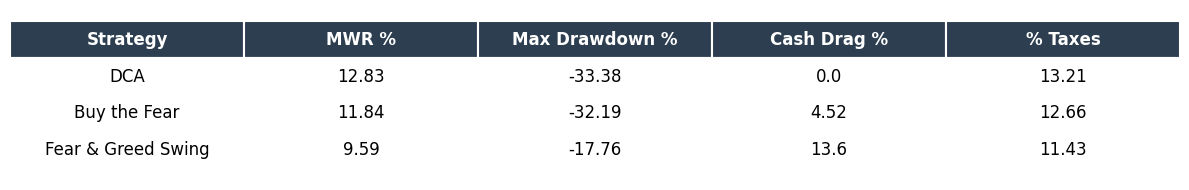

In [8]:

fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('tight')
ax.axis('off')

header_color = '#2c3e50'
row_colors = 'w'

table = ax.table(cellText=df.values, 
                 colLabels=df.columns, 
                 loc='center', 
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor('white')
    cell.set_linewidth(1.5)
    
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(row_colors)
        cell.set_text_props(color='black') # Texto siempre negro

plt.tight_layout()
plt.show()

## Conclusiones
Antes de analizar los resultados, cabe matizar que el objetivo de este análisis no ha sido buscar una exactitud extrema, dejando de lado detalles como los distintos tramos de impuestos sobre ganancias patrimoniales o la rentabilidad para el efectivo no invertido. La intención principal es ofrecer un marco comparativo para observar cómo se comportan estos tres enfoques bajo las mismas condiciones de mercado.

Dicho esto, los datos nos cuentan lo siguiente:

- **El impacto del "Cash Drag" en la rentabilidad.** La estrategia más compleja obtuvo la peor rentabilidad anual (9,60%) frente al DCA (12,83%). La causa principal se observa en la columna de Cash Drag: la estrategia mantuvo el dinero en efectivo un 13,60% del tiempo esperando señales de entrada o salida. Además, la estrategia intermedia, también se quedó por detrás del DCA, debido que el beneficio de precios teóricamente mejores no compensó el tiempo que el dinero estuvo parado esperando la oportunidad. En un ciclo de mercado alcista, no estar invertido al 100% penaliza gravemente el interés compuesto.

- **Reducción de volatilidad vs. Rentabilidad.** La estrategia Fear & Greed Swing no logró batir al mercado en beneficios, pero sí cumplió su función defensiva: redujo el Max Drawdown prácticamente a la mitad (-17,76% frente al -33,38% del DCA). La contrapartida es clara: al vender posiciones para protegerse, la estrategia también se "bajó del tren" antes de tiempo, perdiéndose los tramos más explosivos de las subidas.

Lecciones que me llevo de este experimento:

- Intentar timear el mercado no siempre es la mejor opción, o por lo menos no merece la pena según el tiempo, el estrés y los conocimientos que esto requiere.

- Intentar ajustar los tiempos al extremo muchas veces te hace tener más cash acumulado y perder oportunidades de subida en vez de estar invertido.

- La mejor forma de proteger tu poder adquisitivo frente a la constante degradación monetaria que impulsan las políticas gubernamentales actuales es mantenerte invertido, siendo siempre consciente de los riesgos inherentes a cada tipo de activo.

- Y la regla de oro: **¡Rentabilidades pasadas no aseguran rentabilidades futuras!** Los resultados de este estudio no deben interpretarse como una invitación a invertir todo el patrimonio en el S&P 500; ya que el contexto económico de la próxima década podría ser radicalmente distinto al del periodo analizado aquí.

In [10]:
!jupyter nbconvert --to html --no-input --Application.log_level=CRITICAL strategies.ipynb